In [437]:
#Imports

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


The goals / steps of this project are the following:

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

Apply a distortion correction to raw images.

Use color transforms, gradients, etc., to create a thresholded binary image.

Apply a perspective transform to rectify binary image ("birds-eye view").

Detect lane pixels and fit to find the lane boundary.

Determine the curvature of the lane and vehicle position with respect to center.

Warp the detected lane boundaries back onto the original image.

Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [438]:
# Camera calibration
#Distortion correction
#Color/gradient threshold
# Perspective transform

Input Image:


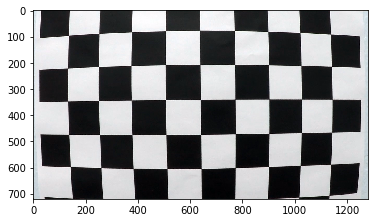

No chessboard croners found for this image


Input Image:


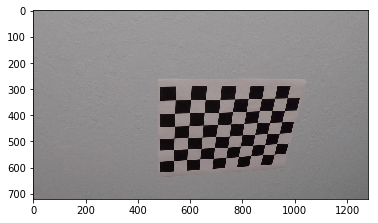

Output Image with chessboard corners:


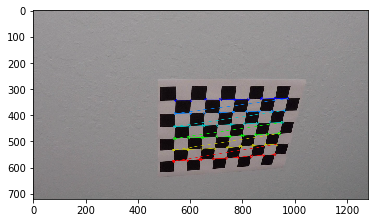

Input Image:


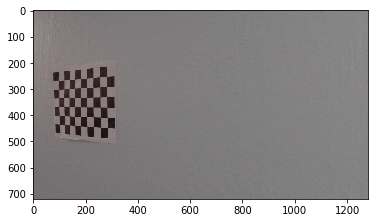

Output Image with chessboard corners:


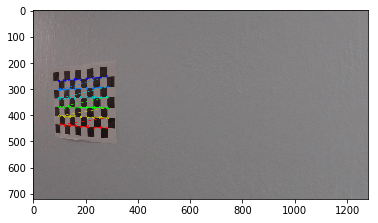

Input Image:


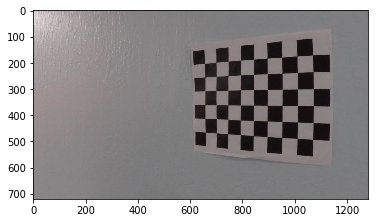

Output Image with chessboard corners:


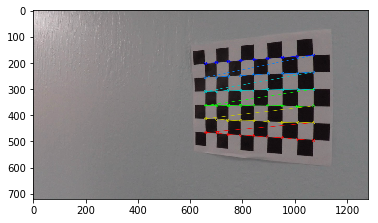

Input Image:


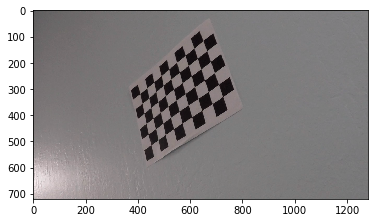

Output Image with chessboard corners:


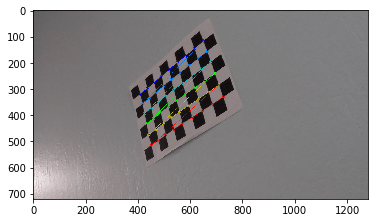

Input Image:


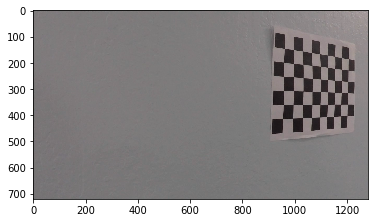

Output Image with chessboard corners:


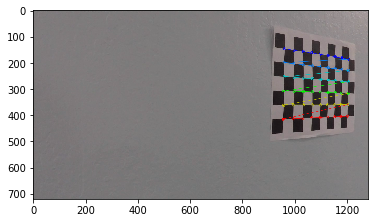

Input Image:


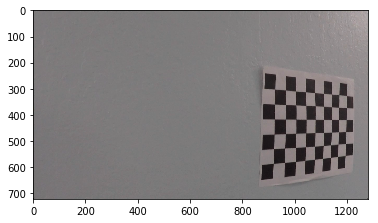

Output Image with chessboard corners:


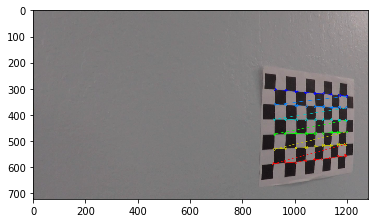

Input Image:


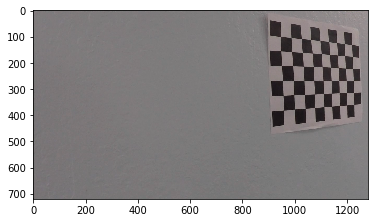

Output Image with chessboard corners:


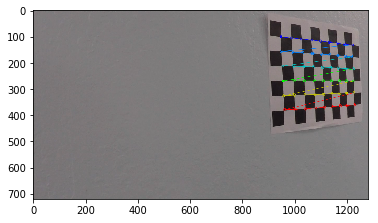

Input Image:


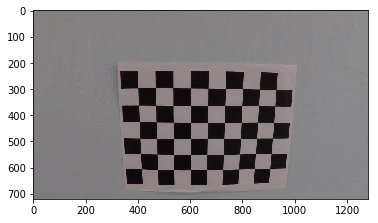

Output Image with chessboard corners:


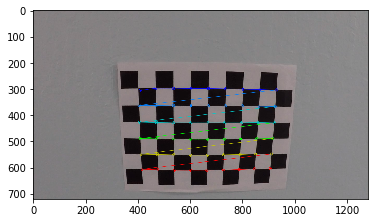

Input Image:


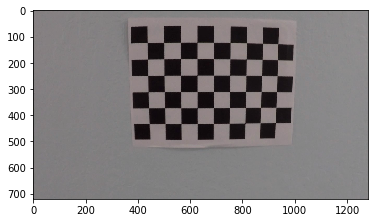

Output Image with chessboard corners:


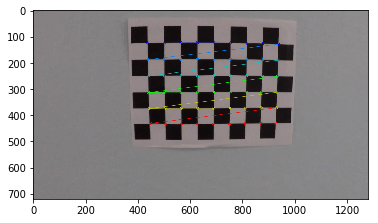

Input Image:


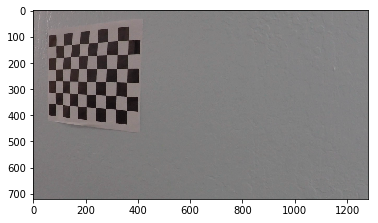

Output Image with chessboard corners:


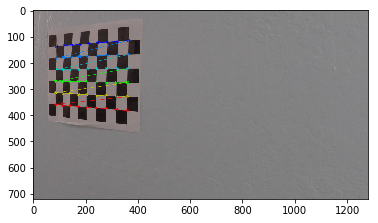

Input Image:


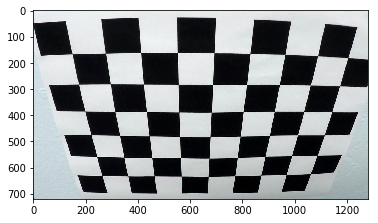

Output Image with chessboard corners:


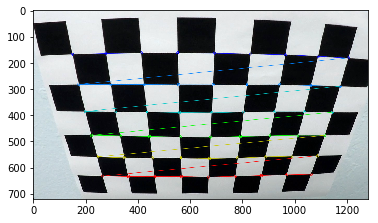

Input Image:


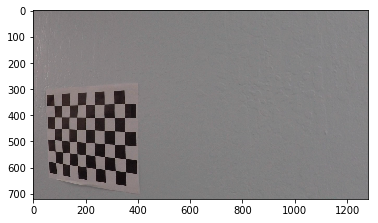

Output Image with chessboard corners:


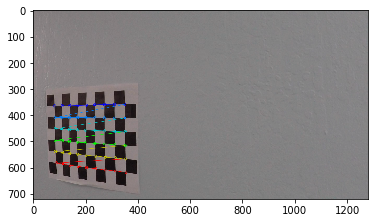

Input Image:


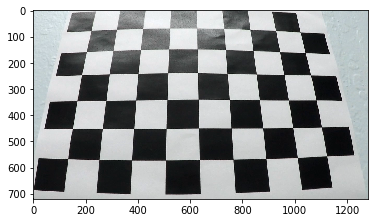

Output Image with chessboard corners:


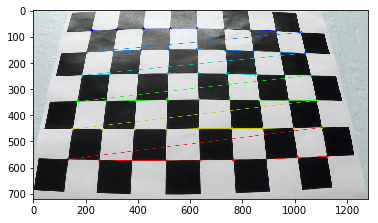

Input Image:


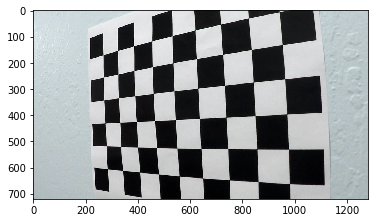

No chessboard croners found for this image


Input Image:


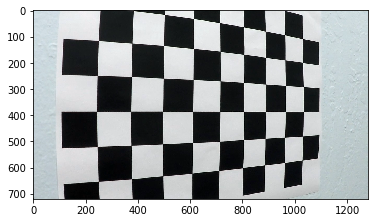

No chessboard croners found for this image


Input Image:


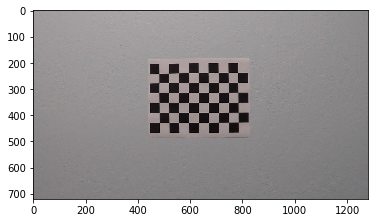

Output Image with chessboard corners:


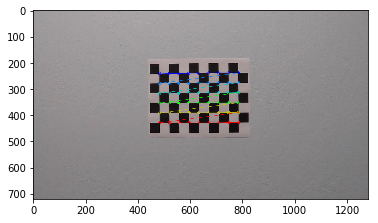

Input Image:


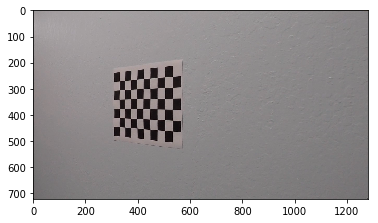

Output Image with chessboard corners:


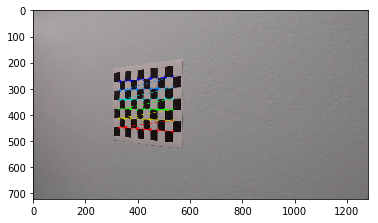

Input Image:


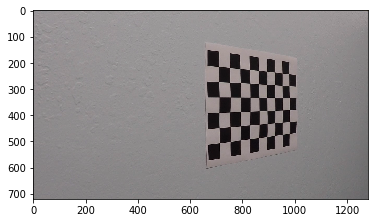

Output Image with chessboard corners:


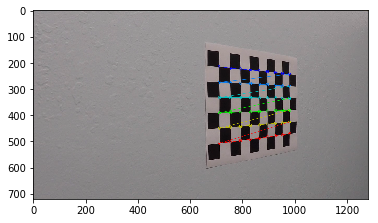

Input Image:


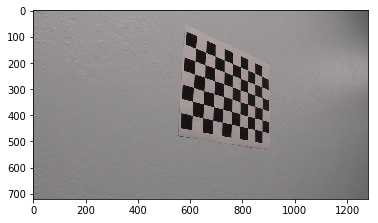

Output Image with chessboard corners:


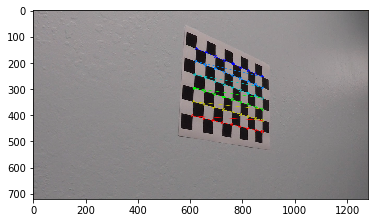

In [439]:
# step1: Camera calibration

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    print("Input Image:")
    plt.imshow(img)
    plt.show()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        print("Output Image with chessboard corners:")
        plt.imshow(img)
        plt.show()
    else:
        print("No chessboard croners found for this image\n\n")
        
    print("=====================================================")




Original image:


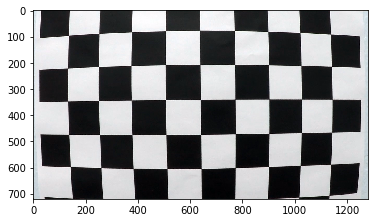

Undistorted image:


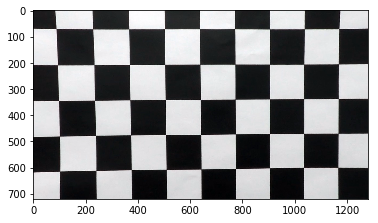

In [440]:
# Obtain the camera calibration matrix

img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Undistort the image using the matrix
dst = cv2.undistort(img, mtx, dist, None, mtx)

# output 
cv2.imwrite('./output_images/calibration1_undist.jpg',dst)
print("Original image:")
plt.imshow(img)
plt.show()

print("Undistorted image:")
plt.imshow(dst)
plt.show()


In [441]:
# takes RGB image as input
def undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


Original image:


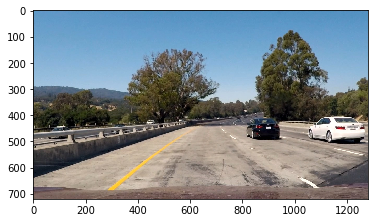

Undistorted image:


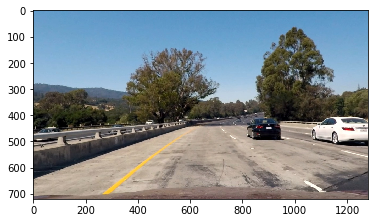

True

In [442]:
# test distort correction on test image
img = cv2.imread('./test_images/test1.jpg')
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("Original image:")
plt.imshow(img1)
plt.show()

dst_img = undistort(img1)

print("Undistorted image:")
plt.imshow(dst_img)
plt.show()
cv2.imwrite('./output_images/test1_undist.jpg',dst_img)



In [443]:
# abs_sobel_thresh

def abs_sobel_thresh(img):

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sxbinary


# magnitude threshold
def magnitude_thresh(img):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # 5) Create a binary mask where mag thresholds are met
    
    thresh_min = 25
    thresh_max = 255
    smbinary = np.zeros_like(scaled_sobel)  
    smbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
     
    return smbinary

def directional_thresh(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=7)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=7)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
        
    # 5) Create a binary mask where direction thresholds are met
    thresh_min = 0
    thresh_max = 0.9
    sdbinary =  np.zeros_like(grad_dir)
    sdbinary[(grad_dir >= thresh_min) & (grad_dir <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return sdbinary



#color transform
def hls_sthresh(img):

    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]


    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    return s_binary

def hls_lthresh(img):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    #l_channel = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    l_thresh_min = 200
    l_thresh_max = 225
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    # 3) Return a binary image of threshold result
    return l_binary

def lab_bthresh(img):
    # 1) Convert to HLS color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    b_channel = lab[:,:,2]
    
    # 2) Apply a threshold to the L channel
    b_thresh_min = 200
    b_thresh_max = 255
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel > b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    # 3) Return a binary image of threshold result
    return b_binary

def combine_binary(binary1, binary2):
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(binary1)
    combined_binary[(binary1 == 1) | (binary2 == 1)] = 1
    
    return combined_binary
    
    


Image: Input image 


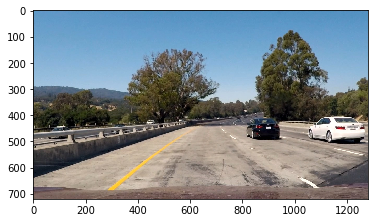

Image: Combined S channel and gradient thresholds


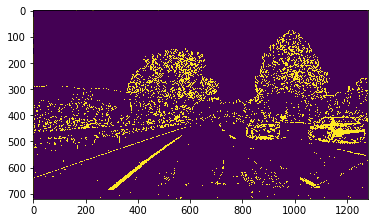

Image: Input image 


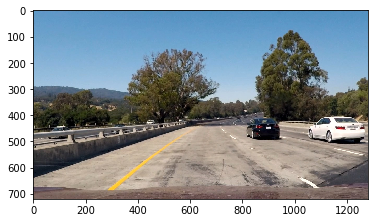

Image: Combined L channel and B channel


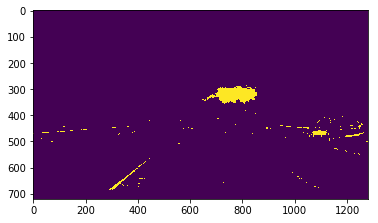

Image: Input image 


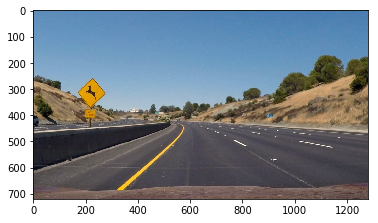

Image: Combined S channel and gradient thresholds


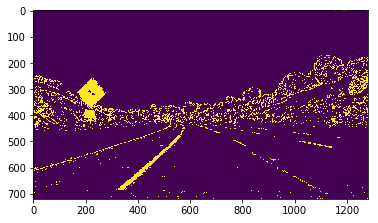

Image: Input image 


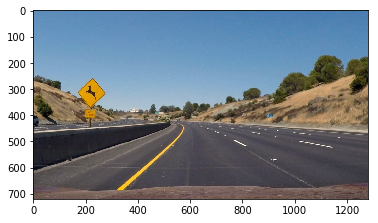

Image: Combined L channel and B channel


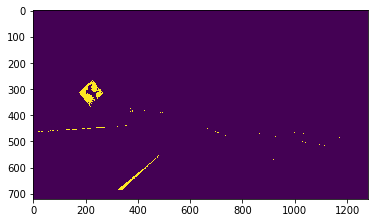

In [444]:
# test thresholds
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
sx_binary = abs_sobel_thresh(img)
s_binary = hls_sthresh(img)
smbinary = magnitude_thresh(img)
sdbinary = directional_thresh(img)
lbinary = hls_lthresh(img)
bbinary = lab_bthresh(img)



combined_binary = combine_binary(sx_binary, s_binary)

print('Image: Input image ')
plt.imshow(img)
plt.show()

print('Image: Combined S channel and gradient thresholds')
plt.imshow(combined_binary)
plt.show()
#cv2.imwrite('./output_images/test1_s_channel_and_gradient_threshold.jpg', combined_binary)


combined_binary = combine_binary(lbinary, bbinary)
print('Image: Input image ')
plt.imshow(img)
plt.show()

print('Image: Combined L channel and B channel')
plt.imshow(combined_binary)
plt.show()



img = cv2.imread('./test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
sx_binary = abs_sobel_thresh(img)
s_binary = hls_select(img)
smbinary = magnitude_thresh(img)
sdbinary = directional_thresh(img)
lbinary = hls_lthresh(img)
bbinary = lab_bthresh(img)

combined_binary = combine_binary(sx_binary, s_binary)

print('Image: Input image ')
plt.imshow(img)
plt.show()

print('Image: Combined S channel and gradient thresholds')
plt.imshow(combined_binary)
plt.show()
#cv2.imwrite('./output_images/test2_s_channel_and_gradient_threshold.jpg', combined_binary)

combined_binary = combine_binary(lbinary, bbinary)
print('Image: Input image ')
plt.imshow(img)
plt.show()

print('Image: Combined L channel and B channel')
plt.imshow(combined_binary)
plt.show()



In [445]:
# Perspective transform
def perspective_transform(img):
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, Minv


Image: Input image 


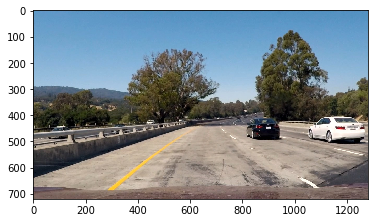

Image: With Perspective Transform


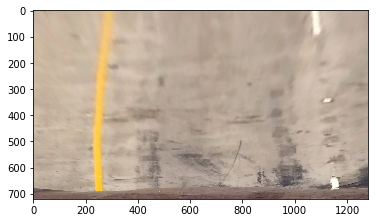

Image: Input image 


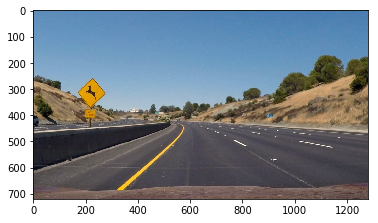

Image: With Perspective Transform


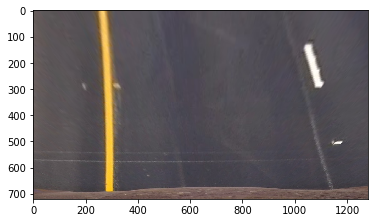

True

In [446]:
# test perspective transform

img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
warped, Minv = perspective_transform(img)
print('Image: Input image ')
plt.imshow(img)
plt.show()

print('Image: With Perspective Transform')
plt.imshow(warped)
plt.show()
cv2.imwrite('./output_images/test1_warped.jpg', warped)


img = cv2.imread('./test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
warped, Minv = perspective_transform(img)
print('Image: Input image ')
plt.imshow(img)
plt.show()

print('Image: With Perspective Transform')
plt.imshow(warped)
plt.show()
cv2.imwrite('./output_images/test2_warped.jpg', warped)


In [447]:
def pipeline_process_image(img):
    udst = undistort(img)
    sx_binary = abs_sobel_thresh(udst)
    s_binary = hls_select(udst)
    smbinary = magnitude_thresh(udst)
    sdbinary = directional_thresh(udst)
    lbinary = hls_lthresh(udst)
    bbinary = lab_bthresh(udst)
    #combined_binary = combine_binary(lbinary, bbinary)
    combined_binary = combine_binary(s_binary, sx_binary)
    #combined_binary = combine_binary(lbinary, bbinary)
    warped, Minv = perspective_transform(combined_binary)
    return warped, Minv
    

Image: Input image 


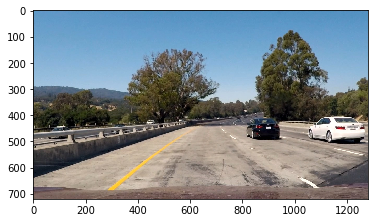

Image: Image processed output 


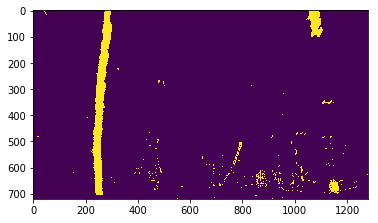

Image: Input image 


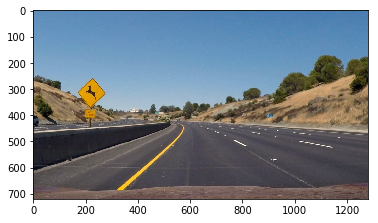

Image: Image processed output 


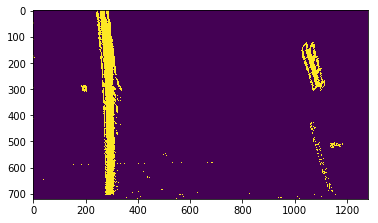

True

In [448]:
img = cv2.imread('./test_images/test1.jpg')
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
new_img, Minv = pipeline_process_image(img1)
print('Image: Input image ')
plt.imshow(img1)
plt.show()

print('Image: Image processed output ')
plt.imshow(new_img)
plt.show()
cv2.imwrite('./output_images/test1_image_processed.jpg', new_img)



img = cv2.imread('./test_images/test2.jpg')
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
new_img, Minv = pipeline_process_image(img1)
print('Image: Input image ')
plt.imshow(img1)
plt.show()

print('Image: Image processed output ')
plt.imshow(new_img)
plt.show()
cv2.imwrite('./output_images/test2_image_processed.jpg', new_img)



In [449]:
# Calculate radius of curvature

def find_curvature(ploty, leftx, rightx, lefty, righty):
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #TODO: print('left_radius_curvature:', left_curverad, 'm', 'right_radius_curvature:', right_curverad, 'm')
    rad_curv = (left_curverad+right_curverad)/2
    #TODO: print('Radius of curvature is:', rad_curv)
    return rad_curv


In [450]:


def find_lines(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    rad_curvature = find_curvature(ploty, leftx, rightx, lefty, righty)

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fitx, right_fitx, out_img, ploty

Image: Input image 


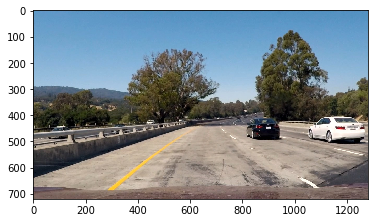

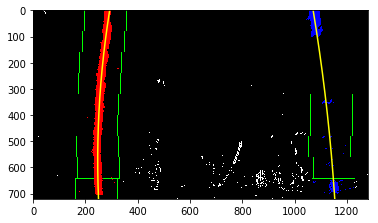

In [451]:

#unit test
img = cv2.imread('./test_images/test1.jpg')
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
warped, Minv = pipeline_process_image(img1)
print('Image: Input image ')
plt.imshow(img1)
plt.show()

left_fitx, right_fitx, out_img, ploty = find_lines(warped)

# Draw lines
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()


In [452]:
# Create an image to draw the lines on
def draw_poly(warped, orig_image, ploty, left_fitx, right_fitx, Minv):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (orig_image.shape[1], orig_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img1, 1, newwarp, 0.3, 0)
    # print(left_curvature, 'm', right_curvature, 'm')
    return result




Image: Input image 


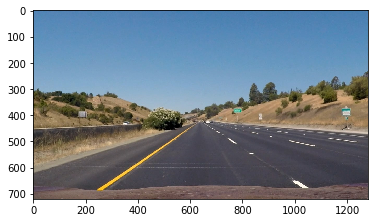

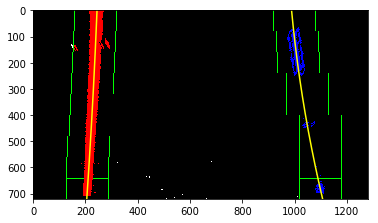

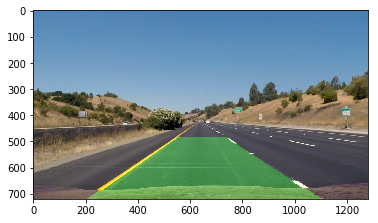

Image: Input image 


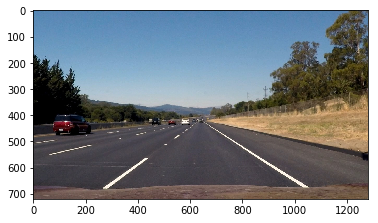

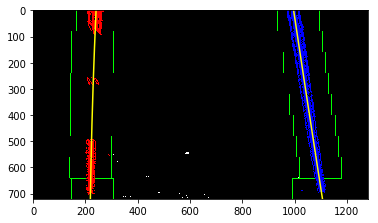

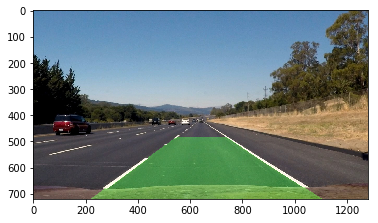

Image: Input image 


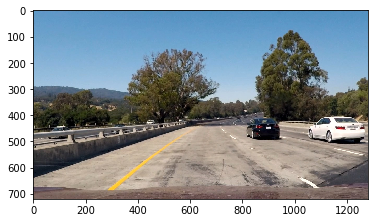

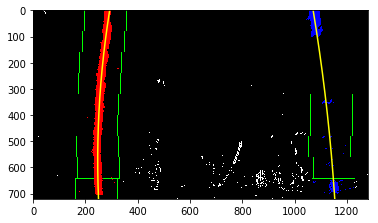

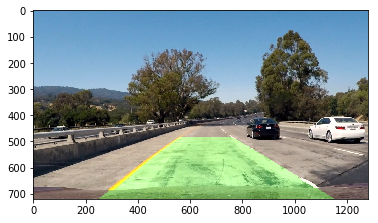

Image: Input image 


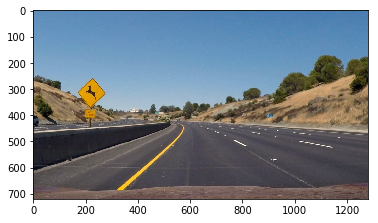

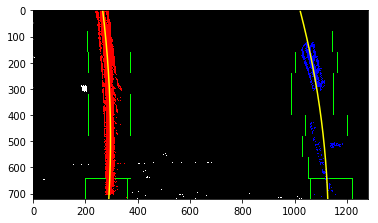

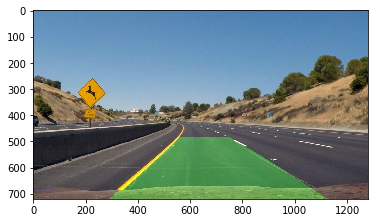

Image: Input image 


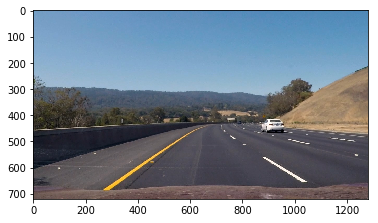

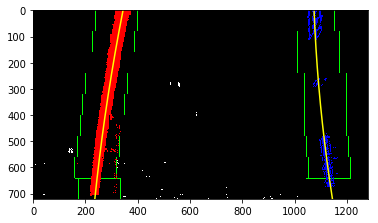

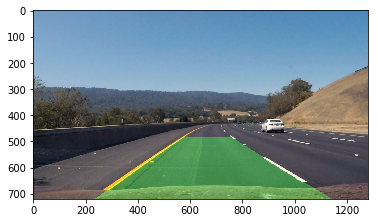

Image: Input image 


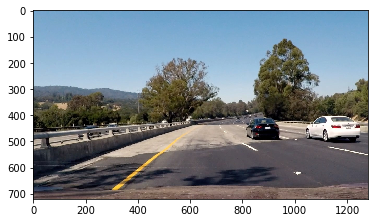

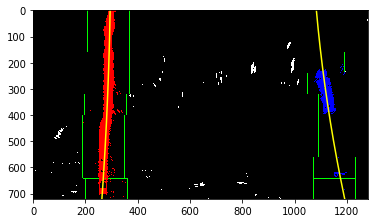

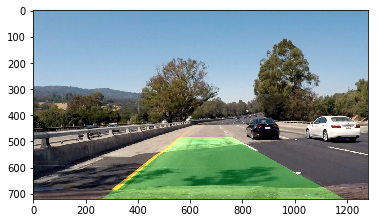

Image: Input image 


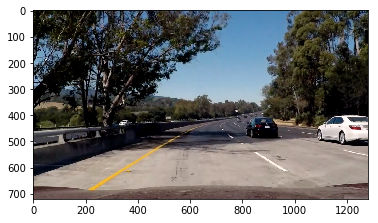

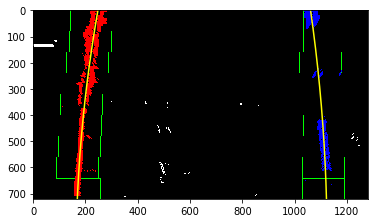

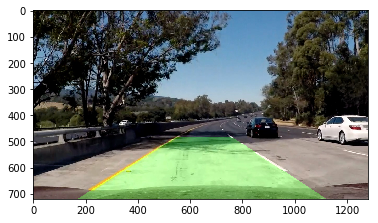

Image: Input image 


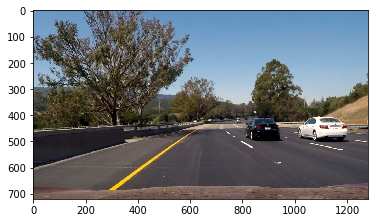

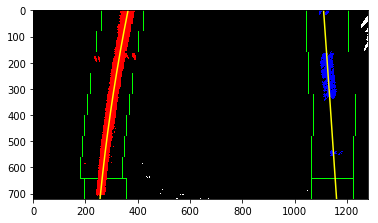

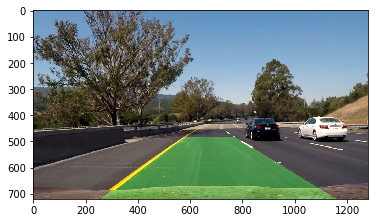

In [453]:
#unit test


images = glob.glob('./test_images/*.jpg')

for idx, fname in enumerate(images):
    
    img = cv2.imread(fname)
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    warped, Minv = pipeline_process_image(img1)
    print('Image: Input image ')
    plt.imshow(img1)
    plt.show()
       
    left_fitx, right_fitx, out_img, ploty = find_lines(warped)
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    
    result = draw_poly(warped, img1, ploty, left_fitx, right_fitx, Minv)
    plt.imshow(result)
    plt.show()



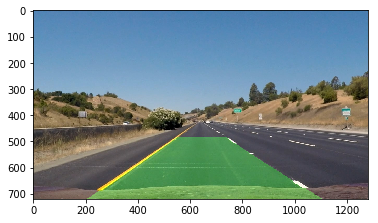

In [465]:
# pipeline for processing an image for video


def process_video_image(img_video):
    warped, Minv = pipeline_process_image(img_video)
    left_fitx, right_fitx, out_img, ploty = find_lines(warped)
    result1 = draw_poly(warped, img_video, ploty, left_fitx, right_fitx, Minv)
    return result1

#unit test
img = cv2.imread('./test_images/straight_lines1.jpg')
result_out = process_video_image(img)
plt.imshow(result_out)
plt.show()

In [471]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'new_vid.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(process_video_image).subclip(0,5) 
video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video new_vid.mp4
[MoviePy] Writing video new_vid.mp4


 99%|█████████▉| 125/126 [00:21<00:00,  5.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: new_vid.mp4 



In [472]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))